# Code with finetuning training:

In [ ]:
from datasets import load_dataset
import json
import pandas as pd
from tqdm import tqdm

# Load the product metadata dataset (raw_meta_Health_and_Personal_Care)
metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Magazine_Subscriptions", trust_remote_code=True)

# Load the product reviews dataset (raw_review_Health_and_Personal_Care)
reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Magazine_Subscriptions", trust_remote_code=True)

# Load the asin2category mapping
with open('/kaggle/input/amazon-reviews-data-2023/asin2category.json', 'r') as f:
    asin2category = json.load(f)

# Preprocess function for product metadata
def preprocess_metadata(metadata, asin2category):
    parent_asin = metadata['parent_asin']
    title = metadata.get('title', "")
    description = " ".join(metadata.get('description', []))  # Join description list into a single string
    features = " ".join(metadata.get('features', []))        # Join features list into a single string
    category = asin2category.get(parent_asin, "Unknown")     # Get category from asin2category

    # Combine all relevant text information
    combined_text = title + " " + description + " " + features
    return {
        'asin': parent_asin,
        'combined_text': combined_text,
        'category': category
    }

# Preprocess function for reviews
def preprocess_reviews(review):
    asin = review['asin']
    review_text = review.get('text', "")
    review_rating = review.get('rating', 0)
    return {
        'asin': asin,
        'review_text': review_text,
        'review_rating': review_rating
    }

# Preprocessing the product metadata dataset
product_data = []
for metadata in tqdm(metadata_dataset['full'], desc="Preprocessing Product Metadata"):
    product_data.append(preprocess_metadata(metadata, asin2category))

# Preprocessing the reviews dataset
review_data = []
for review in tqdm(reviews_dataset['full'], desc="Preprocessing Product Reviews"):
    review_data.append(preprocess_reviews(review))

# Convert both lists to DataFrames
product_df = pd.DataFrame(product_data)
review_df = pd.DataFrame(review_data)

# Preview the DataFrames
print(product_df.head())
print(review_df.head())

# Merge product and review DataFrames on 'asin'
merged_df = pd.merge(product_df, review_df, on='asin', how='inner')

# Display the merged DataFrame
print(merged_df.head())

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

meta_Magazine_Subscriptions.jsonl:   0%|          | 0.00/4.10M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Magazine_Subscriptions.jsonl:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Preprocessing Product Reviews: 100%|██████████| 71497/71497 [00:09<00:00, 7849.28it/s]


         asin                                      combined_text  \
0  B00FA7T630  GQ Print Access    Print Magazine Product Desc...   
1  B00F8P62PO  Hi-Fi +    Print Magazine Hi-Fi+ is Europe's p...   
2  B003F1W9T6                                     Paper Crafts     
3  B00007AXX1                                Horse Illustrated     
4  B00007AZS2                                     Motorcyclist     

                 category  
0  Magazine Subscriptions  
1  Magazine Subscriptions  
2  Magazine Subscriptions  
3  Magazine Subscriptions  
4  Magazine Subscriptions  
         asin                                        review_text  \
0  B00HLSSQKK                Wonderful recipes in this magazine.   
1  B002PXW04Y  Great sports magazine that's on my 9 year olds...   
2  B00HCR5090  "Joy of Kosher" magazine fills a much-needed n...   
3  B0000ARXXS  I've been addicted to Martha Stewart's Everyda...   
4  B0025ZOVEO                                      Too many ads!   

   review_rati

In [ ]:
import torch
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Combine product descriptions and reviews for sentence pair classification with progress bar
def prepare_finetune_data(product_df, review_df):
    fine_tune_data = []
    for idx, row in tqdm(product_df.iterrows(), total=len(product_df), desc="Preparing fine-tuning data"):
        asin = row['asin']
        product_text = row['combined_text']

        # Get the reviews corresponding to this product
        reviews = review_df[review_df['asin'] == asin]['review_text'].tolist()
        for review in reviews:
            fine_tune_data.append({
                'product_text': product_text,
                'review_text': review,
                'label': 1  # Since the review matches the product
            })
    return fine_tune_data

# Prepare dataset with progress bar
fine_tune_data = prepare_finetune_data(product_df, review_df)
fine_tune_df = pd.DataFrame(fine_tune_data)

# Convert pandas DataFrame to Hugging Face Dataset
fine_tune_dataset = Dataset.from_pandas(fine_tune_df)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Preparing fine-tuning data: 100%|██████████| 3391/3391 [00:43<00:00, 77.93it/s]


In [ ]:
from transformers import logging

# Set the logging level of the transformers library to ERROR
logging.set_verbosity_error()

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['product_text'],
        examples['review_text'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_overflowing_tokens=False  # No overflow tokens returned
    )

# Use tqdm with dataset.map() to show progress
tokenized_datasets = fine_tune_dataset.map(tokenize_function, batched=True, desc="Tokenizing data")

Tokenizing data:   0%|          | 0/71497 [00:00<?, ? examples/s]

In [ ]:
# Set up fine-tuning process
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

training_args = TrainingArguments(
    output_dir='./results',           # Output directory
    logging_dir='./logs',             # Directory for storing logs
    per_device_train_batch_size=16,   # Batch size per device
    per_device_eval_batch_size=16,
    num_train_epochs=2,               # Number of epochs
    logging_steps=1000,                # Log every 1000 steps
    save_steps=1000,                  # Save every 1000 steps
    load_best_model_at_end=False,     # No need to load the best model
    gradient_accumulation_steps=2,    # Accumulate gradients over 2 steps
    eval_strategy="no",               # No evaluation
    do_train=True,
    do_eval=False,                    # Disable evaluation
    fp16=True,                        # Enable mixed precision for faster training
    report_to='none',
    disable_tqdm=False,
)

# Fine-tuning with Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,  # Training dataset
)

# Fine-tune the model
trainer.train()

Using device: cuda


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


TrainOutput(global_step=4468, training_loss=0.000670479944644074, metrics={'train_runtime': 7239.1356, 'train_samples_per_second': 19.753, 'train_steps_per_second': 0.617, 'total_flos': 3.761672447376384e+16, 'train_loss': 0.000670479944644074, 'epoch': 1.9995524725889462})

In [ ]:
# Save the fine-tuned model
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')

('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [ ]:
# Load fine-tuned model and tokenizer
from transformers import BertModel
import numpy as np

fine_tuned_model = BertModel.from_pretrained('./fine_tuned_bert').to(device)

# Function to get embeddings from fine-tuned BERT
def get_fine_tuned_bert_embeddings(texts, batch_size=16):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating fine-tuned BERT embeddings"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU

        with torch.no_grad():
            outputs = fine_tuned_model(**inputs)

        # Use the CLS token (first token) embedding and move to CPU before converting to numpy
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Extract the 'product_text' column and convert it to a list
product_texts = fine_tune_df['product_text'].tolist()

# Generate embeddings for the products
product_embeddings = get_fine_tuned_bert_embeddings(product_texts, batch_size=16)

# Convert embeddings to numpy array for similarity calculations
print(product_embeddings.shape)

Generating fine-tuned BERT embeddings: 100%|██████████| 4469/4469 [08:27<00:00,  8.81it/s]

(71497, 768)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to recommend products based on the user query using fine-tuned BERT embeddings
def recommend_products_from_query_finetuned(user_query, product_embeddings, top_n=5):
    # Get embedding for the user query using fine-tuned BERT
    query_embedding = get_fine_tuned_bert_embeddings([user_query])[0]

    # Calculate cosine similarity between user query and product embeddings
    similarities = cosine_similarity([query_embedding], product_embeddings)[0]

    # Add similarities to the DataFrame
    merged_df['similarity_score'] = similarities

    # Sort by similarity score
    recommendations_df = merged_df.sort_values(by='similarity_score', ascending=False)

    # Remove duplicate ASINs
    recommendations_df = recommendations_df.drop_duplicates(subset='asin', keep='first')

    # Return top N unique products
    return recommendations_df.head(top_n)

# Example usage: User query to search for relevant products
user_query = "Animals or wildlife"
top_n = 5  # Number of unique recommendations to return
recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)

# Display recommended products with unique ASINs and similarity scores
print("Recommended Products based on the query:")
print(recommended_products[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s]


Recommended Products based on the query:
                  combined_text  similarity_score
67002     Texas Fish and Game            0.992842
71138  Meat Goat Monthly News            0.992835
2652              Guns & Ammo            0.992761
44458             Guns & Ammo            0.992761
62803          Art & Antiques            0.992755


In [ ]:
# Example usage: User query to search for relevant products
user_query = "Healthcare"
top_n = 5  # Number of unique recommendations to return
recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)

# Display recommended products with unique ASINs and similarity scores
print("Recommended Products based on the query:")
print(recommended_products[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.48it/s]


Recommended Products based on the query:
             combined_text  similarity_score
41192    Experience Life            0.994107
66962    Experience Life            0.994107
47696  Sporting Classics            0.994044
63819        Pizza Today            0.993948
71230       American Spa            0.993931


In [ ]:
# Example usage: User query to search for relevant products
user_query = "What are the best magazine subscriptions for someone interested in technology and innovation?"
top_n = 5  # Number of unique recommendations to return
recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)

# Display recommended products with unique ASINs and similarity scores
print("Recommended Products based on the query:")
print(recommended_products[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 43.22it/s]


Recommended Products based on the query:
                                           combined_text  similarity_score
65469  OK! Magazine    Print Magazine Packed with siz...          0.998125
9858   American Cheerleader    Print Magazine The mag...          0.998103
13737  Underhood Service    Print Magazine Underhood ...          0.998102
4767   Scots Magazine    Print Magazine Features arti...          0.998069
27112  Fortune    Print Magazine Fortune offers reade...          0.998024


In [ ]:
# Example usage: User query to search for relevant products
user_query = "What are the top-rated science fiction magazines?"
top_n = 5  # Number of unique recommendations to return
recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)

# Display recommended products with unique ASINs and similarity scores
print("Recommended Products based on the query:")
print(recommended_products[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Recommended Products based on the query:
                                           combined_text  similarity_score
53058  Strictly Slots    Print Magazine A magazine fo...          0.996867
66942  Non-No - Woman    Print Magazine Japanese maga...          0.996588
65469  OK! Magazine    Print Magazine Packed with siz...          0.996575
58493  BMX Plus    Print Magazine Reports on the star...          0.996569
66527  Looney Tunes    Print Magazine Features storie...          0.996517


In [ ]:
# Example usage: User query to search for relevant products
user_query = "Show me magazines that focus on both business insights and technology trends."
top_n = 5  # Number of unique recommendations to return
recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)

# Display recommended products with unique ASINs and similarity scores
print("Recommended Products based on the query:")
print(recommended_products[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]


Recommended Products based on the query:
                                           combined_text  similarity_score
50093  Swat : Special Weapons & Tactics for the Prepa...          0.998124
71494  Visto    Print Magazine A news magazine target...          0.998068
40817  Dumbo Feather    Print Magazine Each issue fea...          0.998023
64782  Vogue Australia    Print Magazine Magazine rep...          0.998021
10223  BBC Wildlife    Print Magazine BBC Wildlife is...          0.997969


## LIME

In [ ]:
from lime.lime_text import LimeTextExplainer

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=['Not Recommended', 'Recommended'])

# Define a prediction function that LIME can use
import torch

def predict_proba_lime(texts):
    # Check if the model is on GPU and move inputs to the same device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Tokenize the inputs and move them to the appropriate device
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)

    # Move model to the same device
    model.to(device)

    # Get predictions
    with torch.no_grad():
        logits = model(**inputs).logits
        probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

    return probabilities

# Sample user query for analysis
user_query = "Show me magazines that focus on both business insights and technology trends."

# Generate LIME explanation for this query
explanation = explainer.explain_instance(user_query, predict_proba_lime)

# Show the LIME explanation
explanation.show_in_notebook()

In [ ]:
user_query = "What are the top-rated science fiction magazines?"
explanation = explainer.explain_instance(user_query, predict_proba_lime)
explanation.show_in_notebook()

In [ ]:
user_query = "What are the best magazine subscriptions for someone interested in technology and innovation?"
explanation = explainer.explain_instance(user_query, predict_proba_lime)
explanation.show_in_notebook()

## Attention Weights

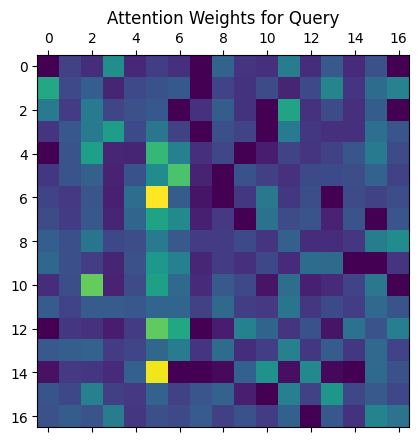

In [ ]:
import matplotlib.pyplot as plt

# Get the attention weights from the BERT model
inputs = tokenizer(user_query, return_tensors='pt').to(device)
outputs = model(**inputs, output_attentions=True)

# Extract attention weights from the first layer
attention_weights = outputs.attentions[0].cpu().detach().numpy()

# Plot attention weights for visualization
plt.matshow(attention_weights[0][0])
plt.title("Attention Weights for Query")
plt.show()

## Counterfactual Explanations

In [ ]:
# Example: Slightly modify the user query
modified_query = "Animals and nature photography"

# Generate new recommendations for the modified query
modified_recommendations = recommend_products_from_query_finetuned(modified_query, product_embeddings, top_n)

# Compare original vs modified recommendations
print("Original Recommendations:")
print(recommended_products[['combined_text', 'similarity_score']])
print("Modified Recommendations:")
print(modified_recommendations[['combined_text', 'similarity_score']])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]


Original Recommendations:
                                           combined_text  similarity_score
50093  Swat : Special Weapons & Tactics for the Prepa...          0.998124
71494  Visto    Print Magazine A news magazine target...          0.998068
40817  Dumbo Feather    Print Magazine Each issue fea...          0.998023
64782  Vogue Australia    Print Magazine Magazine rep...          0.998021
10223  BBC Wildlife    Print Magazine BBC Wildlife is...          0.997969
Modified Recommendations:
                                           combined_text  similarity_score
20418  Freshwater and Marine Aquarium    Print Magazi...          0.996315
44994  Freshwater and Marine Aquarium    Print Magazi...          0.996314
11124                 Car and Driver    Print Magazine            0.996054
20498                 Car and Driver    Print Magazine            0.996054
43478                 Car and Driver    Print Magazine            0.996054


## Attention Maps

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your tokenizer and model
model_name = "./fine_tuned_bert"  # Change this to your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)

def predict_proba_attmap(query):
    # Tokenize the input
    inputs = tokenizer(query, return_tensors="pt")

    # Forward pass to get outputs and attention weights
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract logits and attention weights
    logits = outputs.logits
    attention_weights = outputs.attentions

    # Get softmax probabilities
    probabilities = logits.softmax(dim=-1).cpu().numpy()

    # Return probabilities and attention weights
    return probabilities, attention_weights

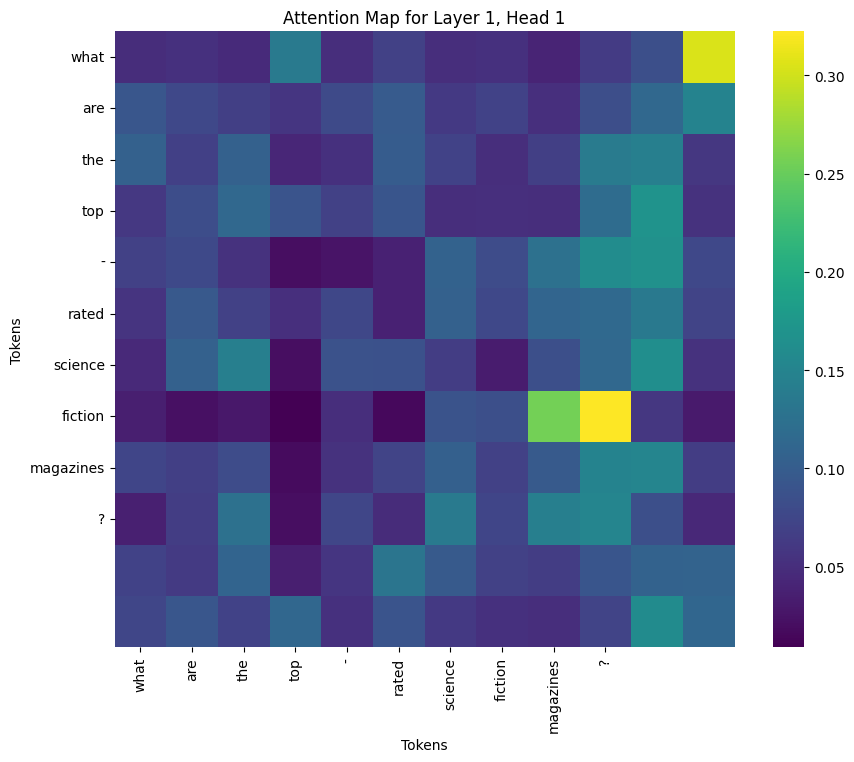

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(attention_weights, input_tokens):
    # Select the attention weights from a specific layer and head
    layer_index = 0  # Change this if you want another layer
    head_index = 0  # Change this if you want another head

    # Get attention weights for the selected layer and head
    attention = attention_weights[layer_index][0, head_index].detach().numpy()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=input_tokens, yticklabels=input_tokens, cmap="viridis", cbar=True)
    plt.title(f'Attention Map for Layer {layer_index + 1}, Head {head_index + 1}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Example usage
user_query = "What are the top-rated science fiction magazines?"
probabilities, attention_weights = predict_proba_attmap(user_query)
input_tokens = tokenizer.tokenize(user_query)

# Plot the attention map
plot_attention_map(attention_weights, input_tokens)

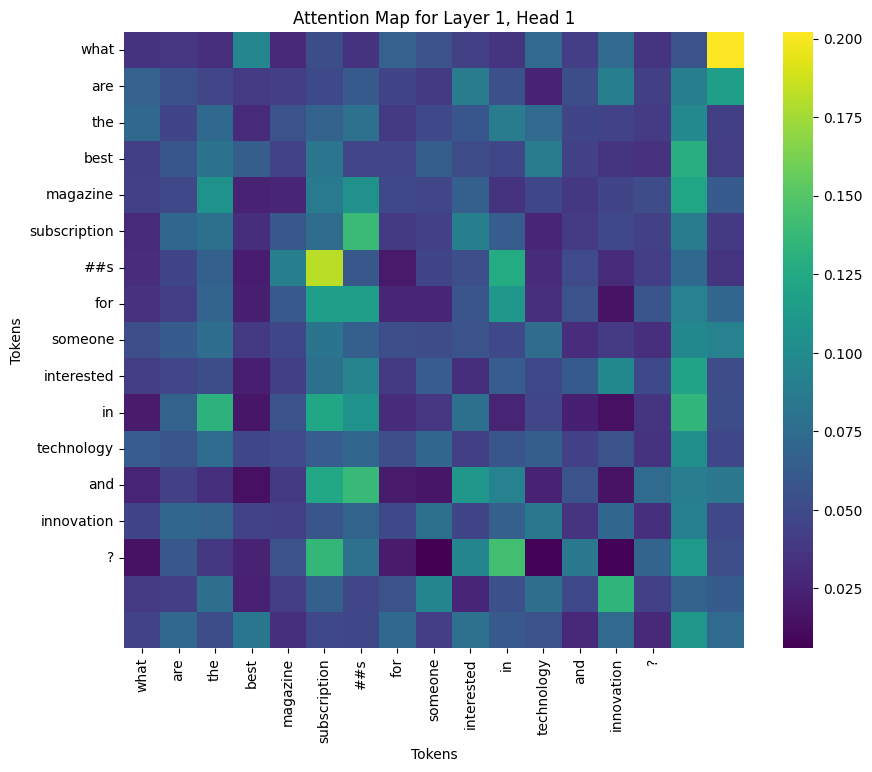

In [ ]:
# Example usage
user_query = "What are the best magazine subscriptions for someone interested in technology and innovation?"
probabilities, attention_weights = predict_proba_attmap(user_query)
input_tokens = tokenizer.tokenize(user_query)

# Plot the attention map
plot_attention_map(attention_weights, input_tokens)

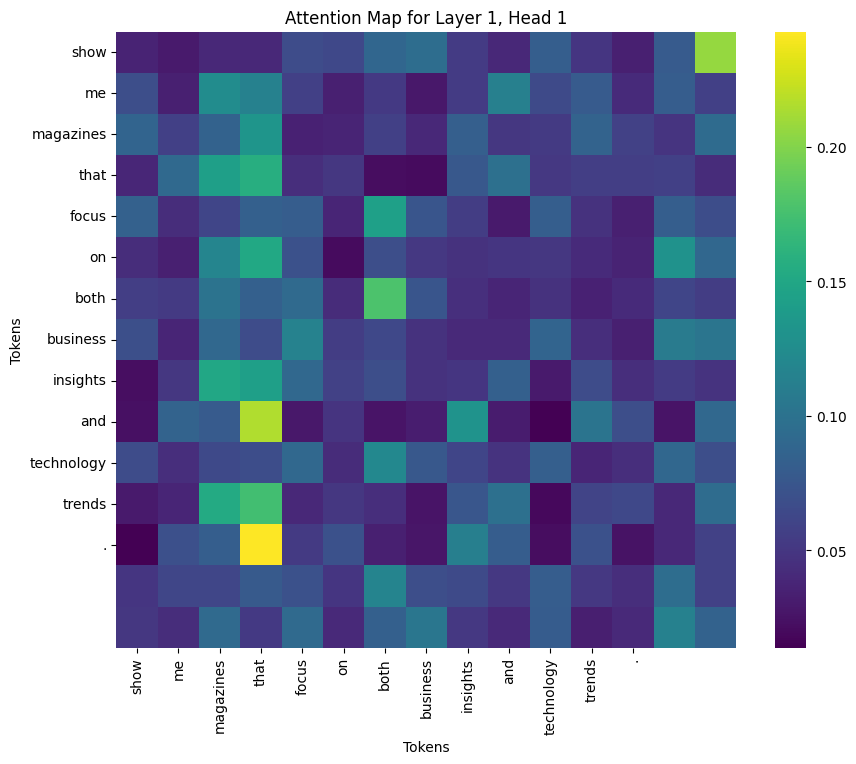

In [ ]:
# Example usage
user_query = "Show me magazines that focus on both business insights and technology trends."
probabilities, attention_weights = predict_proba_attmap(user_query)
input_tokens = tokenizer.tokenize(user_query)

# Plot the attention map
plot_attention_map(attention_weights, input_tokens)

In [ ]:
import shap
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

# Define the model_predict function to process raw text and return cosine similarity
def model_predict(texts):
    # Flattening the input list of lists to a single list of strings
    flattened_list = list(itertools.chain.from_iterable(texts))  # Use itertools to flatten

    # Ensure input is a list of strings
    if not all(isinstance(text, str) for text in flattened_list):
        raise ValueError("Input to model_predict must be a list of strings")

    # Convert texts to embeddings
    embeddings = get_fine_tuned_bert_embeddings(flattened_list, batch_size=16)

    # Get embedding for the user query
    query_embedding = get_fine_tuned_bert_embeddings([user_query])[0]

    # Calculate cosine similarity between user query and product embeddings
    similarities = cosine_similarity([query_embedding], embeddings)[0]

    return similarities


# Initialize SHAP explainer using the sample product texts
explainer = shap.KernelExplainer(model_predict, fine_tune_df['product_text'])

# Generate SHAP values for these products
shap_values = explainer.shap_values(fine_tune_df['product_text'])

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


In [ ]:
# Ensure proper SHAP values for the first product
shap_values_single = shap_values[1000]  # Get SHAP values for the first product
print(sum(shap_values))
# Initialize JavaScript visualization
shap.initjs()

# Convert the text input to a format for visualization
product_text = fine_tune_df['product_text']
flattened_list = list(itertools.chain.from_iterable(product_text))

# Visualize SHAP values using force_plot
# shap.force_plot(
#     explainer.expected_value,     # Baseline value (average prediction)
#     shap_values_single,           # SHAP values for the first product
#     flattened_list[0]                  # Original product text (or features) for display
# )


0.0


# Multi-level Explanations!

## User expertise based levels:
1. **Basic**: Provide simple explanations using the overall context of the query, like product category matching and review scores.
2. **Intermediate**: Highlight specific keywords or phrases contributing to the recommendation using attention weights or extracted terms.
3. **Advanced**: Use SHAP, LIME, or attention to provide detailed explanations, such as specific features or words contributing most to the recommendation.

Basic Level Recommendations and Explanations:


Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 89.94it/s]


Recommended Products based on the query:
                  combined_text  similarity_score
67002     Texas Fish and Game            0.992842
71138  Meat Goat Monthly News            0.992835
2652              Guns & Ammo            0.992761
44458             Guns & Ammo            0.992761
62803          Art & Antiques            0.992755

Intermediate Level Recommendations and Explanations:


Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Recommended Products based on the query:
                  combined_text  similarity_score
67002     Texas Fish and Game            0.992842
71138  Meat Goat Monthly News            0.992835
2652              Guns & Ammo            0.992761
44458             Guns & Ammo            0.992761
62803          Art & Antiques            0.992755
Why have we recommended this to you?



Advanced Level Recommendations and Explanations:


Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


Recommended Products based on the query:
                  combined_text  similarity_score
67002     Texas Fish and Game            0.992842
71138  Meat Goat Monthly News            0.992835
2652              Guns & Ammo            0.992761
44458             Guns & Ammo            0.992761
62803          Art & Antiques            0.992755
Why have we recommended this to you?


Attention maps to visualize which part has played a bigger role in the above recommendations:


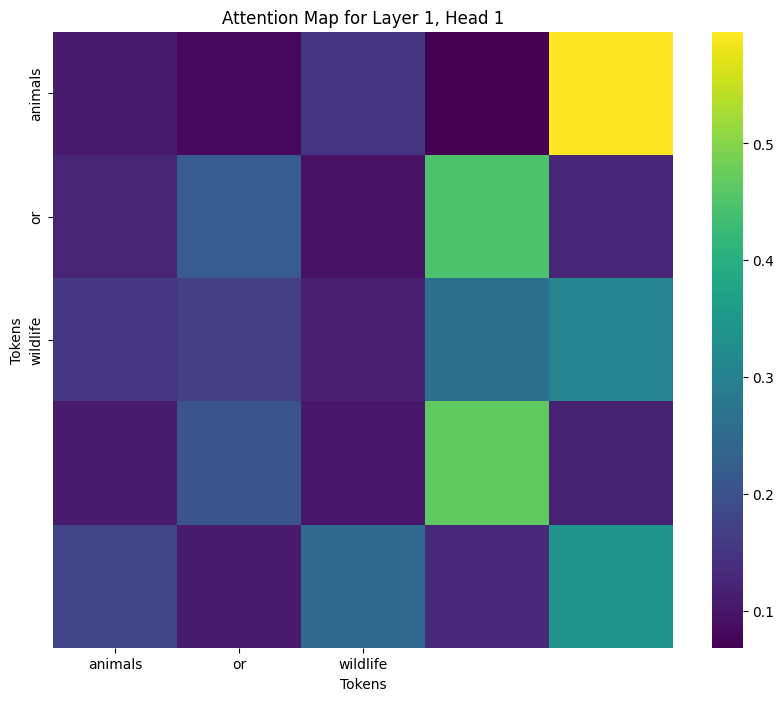

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import shap
import lime
from lime.lime_text import LimeTextExplainer

# Example usage: User query to search for relevant products
#user_query = "Show me magazines that focus on both business insights and technology trends."
top_n = 5  # Number of unique recommendations to return


# Display recommended products with unique ASINs and similarity scores


# Function for basic level explanation: simple recommendation
def explain_basic(user_query):
    recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)
    print("Recommended Products based on the query:")
    print(recommended_products[['combined_text', 'similarity_score']])

# Function for intermediate level explanation - recommends + LIME
def explain_intermediate(user_query):
    recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)
    print("Recommended Products based on the query:")
    print(recommended_products[['combined_text', 'similarity_score']])
    print("Why have we recommended this to you?")
    explainer = LimeTextExplainer(class_names=['Not Recommended', 'Recommended'])
    explanation = explainer.explain_instance(user_query, predict_proba_lime)
    explanation.show_in_notebook()

# Function for advanced level explanation - recommends + LIME + Counterfactual/Attention maps
def explain_advanced(user_query):
    recommended_products = recommend_products_from_query_finetuned(user_query, product_embeddings, top_n)
    print("Recommended Products based on the query:")
    print(recommended_products[['combined_text', 'similarity_score']])
    print("Why have we recommended this to you?")
    explainer = LimeTextExplainer(class_names=['Not Recommended', 'Recommended'])
    explanation = explainer.explain_instance(user_query, predict_proba_lime)
    explanation.show_in_notebook()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Attention maps to visualize which part has played a bigger role in the above recommendations:")
    #ATTENTION MAPS CODE:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load your tokenizer and model
    model_name = "./fine_tuned_bert"  # Change this to your desired model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)

    def predict_proba_attmap(query):
        # Tokenize the input
        inputs = tokenizer(query, return_tensors="pt")

        # Forward pass to get outputs and attention weights
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract logits and attention weights
        logits = outputs.logits
        attention_weights = outputs.attentions

        # Get softmax probabilities
        probabilities = logits.softmax(dim=-1).cpu().numpy()

        # Return probabilities and attention weights
        return probabilities, attention_weights

    def plot_attention_map(attention_weights, input_tokens):
        # Select the attention weights from a specific layer and head
        layer_index = 0  # Change this if you want another layer
        head_index = 0  # Change this if you want another head

        # Get attention weights for the selected layer and head
        attention = attention_weights[layer_index][0, head_index].detach().numpy()

        # Create a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention, xticklabels=input_tokens, yticklabels=input_tokens, cmap="viridis", cbar=True)
        plt.title(f'Attention Map for Layer {layer_index + 1}, Head {head_index + 1}')
        plt.xlabel('Tokens')
        plt.ylabel('Tokens')
        plt.show()

    probabilities, attention_weights = predict_proba_attmap(user_query)
    input_tokens = tokenizer.tokenize(user_query)
    # Plot the attention map
    plot_attention_map(attention_weights, input_tokens)

# Recommendation function with expertise level-based explanation
def recommend_products_with_explanation(user_query, expertise_level='basic'):
    # Generate explanations based on expertise level
    if expertise_level == 'basic':
        explain_basic(user_query)
    elif expertise_level == 'intermediate':
        explain_intermediate(user_query)
    elif expertise_level == 'advanced':
        explain_advanced(user_query)
    else:
        ["Invalid expertise level specified."]

# Example usage
user_query = "Animals or wildlife"
top_n = 5  # Number of unique recommendations to return

# Test basic explanation
print("Basic Level Recommendations and Explanations:")
basic_recommendations = recommend_products_with_explanation(user_query, expertise_level='basic')

# Test intermediate explanation
print("\nIntermediate Level Recommendations and Explanations:")
intermediate_recommendations = recommend_products_with_explanation(user_query, expertise_level='intermediate')

# Test advanced explanation
print("\nAdvanced Level Recommendations and Explanations:")
advanced_recommendations = recommend_products_with_explanation(user_query, expertise_level='advanced')

## Context-aware explanations:

1. **Basic Level**: Simple, context-aware explanations. For example, “Based on your recent searches, we recommend this.”
2. **Advanced Level**: Uses more sophisticated counterfactual explanations. For example, “If you had looked for Y instead of X, you would have received this alternative product.”

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import shap
from lime.lime_text import LimeTextExplainer
import numpy as np

# Context-aware explanation helper function (uses user session and history)
def get_user_context(session_data, user_history):
    # Combine session and history context into a simple summary
    session_context = f"recent searches: {', '.join(session_data)}"
    history_context = f"past purchases: {', '.join(user_history)}"
    return session_context, history_context

# Counterfactual explanation helper function
def generate_counterfactual_explanation(original_query, alternative_query, product_embeddings, top_n=5):
    # Get embeddings for alternative query
    alt_query_embedding = get_fine_tuned_bert_embeddings([alternative_query])[0]

    # Calculate cosine similarity for the alternative query
    similarities = cosine_similarity([alt_query_embedding], product_embeddings)[0]

    # Add similarities to the DataFrame
    merged_df['alt_similarity_score'] = similarities

    # Sort by alternative similarity score
    alt_recommendations_df = merged_df.sort_values(by='alt_similarity_score', ascending=False).drop_duplicates(subset='asin', keep='first').head(top_n)

    return alt_recommendations_df[['combined_text', 'alt_similarity_score']]

# Function for basic level explanation (context-aware)
def explain_basic_context(recommendations_df, session_context):
    explanations = []
    for _, row in recommendations_df.iterrows():
        explanation = f"Recommended '{row['combined_text'][:50]}...' based on your {session_context}."
        explanations.append(explanation)
    return explanations

# Function for advanced level explanation (context-aware + detailed counterfactuals)
def explain_advanced_context_counterfactual(recommendations_df, user_query, alternative_query, product_embeddings):
    explanations = []

    # Generate counterfactual recommendations for the alternative query
    alt_recommendations_df = generate_counterfactual_explanation(user_query, alternative_query, product_embeddings)

    # Iterate through the main recommendations and generate explanations
    for idx, row in recommendations_df.iterrows():
        explanation = f"Recommended '{row['combined_text'][:50]}...' due to your search for '{user_query}'."

        # Check if there's a corresponding counterfactual recommendation
        if idx < len(alt_recommendations_df):
            alt_text = alt_recommendations_df.iloc[idx]['combined_text'][:50]
            explanation += f" If you had searched for '{alternative_query}', we would have recommended '{alt_text}...' instead."
        else:
            # Handle case where there is no corresponding counterfactual recommendation
            explanation += " No alternative recommendation available."

        explanations.append(explanation)

    return explanations

# Recommendation function with expertise level-based explanation
def recommend_products_with_explanation(user_query, product_embeddings, top_n=5, expertise_level='basic', session_data=None, user_history=None, alternative_query=None):
    # Get embedding for the user query using fine-tuned BERT
    query_embedding = get_fine_tuned_bert_embeddings([user_query])[0]

    # Calculate cosine similarity between user query and product embeddings
    similarities = cosine_similarity([query_embedding], product_embeddings)[0]

    # Add similarities to the DataFrame
    merged_df['similarity_score'] = similarities

    # Sort by similarity score and drop duplicates
    recommendations_df = merged_df.sort_values(by='similarity_score', ascending=False).drop_duplicates(subset='asin', keep='first').head(top_n)

    # Get user context (recent searches, history)
    session_context, history_context = get_user_context(session_data, user_history)

    # Generate explanations based on expertise level
    if expertise_level == 'basic':
        explanations = explain_basic_context(recommendations_df, session_context)
    elif expertise_level == 'advanced' and alternative_query:
        explanations = explain_advanced_context_counterfactual(recommendations_df, user_query, alternative_query, product_embeddings)
    else:
        explanations = ["Invalid expertise level or missing alternative query."]

    # Return recommendations with explanations
    recommendations_df['explanation'] = explanations
    return recommendations_df[['combined_text', 'similarity_score', 'explanation']]

# Example usage
user_query = "Animals or wildlife"
alternative_query = "Photography"  # Counterfactual query
session_data = ["wildlife magazines", "nature photography"]
user_history = ["National Geographic", "Bird Watching Magazine"]

top_n = 5  # Number of unique recommendations to return

# Test basic context-aware explanation
basic_recommendations = recommend_products_with_explanation(user_query, product_embeddings, top_n, expertise_level='basic', session_data=session_data, user_history=user_history)
print("Basic Level Context-Aware Recommendations and Explanations:")
print(basic_recommendations)

# Test advanced context-aware + detailed counterfactual explanation
advanced_recommendations = recommend_products_with_explanation(user_query, product_embeddings, top_n, expertise_level='advanced', session_data=session_data, user_history=user_history, alternative_query=alternative_query)
print("\nAdvanced Level Context-Aware + Detailed Counterfactual Recommendations and Explanations:")
print(advanced_recommendations)

Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.15it/s]


Basic Level Context-Aware Recommendations and Explanations:
                  combined_text  similarity_score  \
67002     Texas Fish and Game            0.992842   
71138  Meat Goat Monthly News            0.992835   
2652              Guns & Ammo            0.992761   
44458             Guns & Ammo            0.992761   
62803          Art & Antiques            0.992755   

                                             explanation  
67002  Recommended 'Texas Fish and Game  ...' based o...  
71138  Recommended 'Meat Goat Monthly News  ...' base...  
2652   Recommended 'Guns & Ammo  ...' based on your r...  
44458  Recommended 'Guns & Ammo  ...' based on your r...  
62803  Recommended 'Art & Antiques  ...' based on you...  


Generating fine-tuned BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.88it/s]



Advanced Level Context-Aware + Detailed Counterfactual Recommendations and Explanations:
                  combined_text  similarity_score  \
67002     Texas Fish and Game            0.992842   
71138  Meat Goat Monthly News            0.992835   
2652              Guns & Ammo            0.992761   
44458             Guns & Ammo            0.992761   
62803          Art & Antiques            0.992755   

                                             explanation  
67002  Recommended 'Texas Fish and Game  ...' due to ...  
71138  Recommended 'Meat Goat Monthly News  ...' due ...  
2652   Recommended 'Guns & Ammo  ...' due to your sea...  
44458  Recommended 'Guns & Ammo  ...' due to your sea...  
62803  Recommended 'Art & Antiques  ...' due to your ...  


# Comparison with base models:

Pretrained models used:
1. **DistilBERT:** (works well)

     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
     model = AutoModel.from_pretrained("distilbert-base-uncased")

2. **M6-Rec:** (some padding error)

    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    
    model = AutoModel.from_pretrained("gpt2")

3. **UniSRec:** (Private repository)

    tokenizer = AutoTokenizer.from_pretrained("unified-sequential/unisrec")
    
    model = AutoModel.from_pretrained("unified-sequential/unisrec")
    
4. **Bert4Rec** (Private repository)

    tokenizer = AutoTokenizer.from_pretrained("bert4rec/bert4rec-base")
    
    model = AutoModel.from_pretrained("bert4rec/bert4rec-base")
    
5. **Blair:** (works well)
    tokenizer = AutoTokenizer.from_pretrained("hyp1231/blair-roberta-base")
    model = AutoModel.from_pretrained("hyp1231/blair-roberta-base")
    
6. **Our Model:**
    tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_bert')
    model = AutoModel.from_pretrained('./fine_tuned_bert')

## Our model:

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_bert')
model = AutoModel.from_pretrained('./fine_tuned_bert')

language_context = 'I need a product that can scoop, measure, and rinse grains without the need for multiple utensils and dishes. It would be great if the product has measurements inside and the ability to rinse and drain all in one. I just have to be careful not to pour too much accidentally.'
item_metadata = [
  'Talisman Designs 2-in-1 Measure Rinse & Strain | Holds up to 2 Cups | Food Strainer | Fruit Washing Basket | Strainer & Colander for Kitchen Sink | Dishwasher Safe - Dark Blue. The Measure Rinse & Strain by Talisman Designs is a 2-in-1 kitchen colander and strainer that will measure and rinse up to two cups. Great for any type of food from rice, grains, beans, fruit, vegetables, pasta and more. After measuring, fill with water and swirl to clean. Strain then pour into your pot, pan, or dish. The convenient size is easy to hold with one hand and is compact to fit into a kitchen cabinet or pantry. Dishwasher safe and food safe.',
  'FREETOO Airsoft Gloves Men Tactical Gloves for Hiking Cycling Climbing Outdoor Camping Sports (Not Support Screen Touch).'
]
texts = [language_context] + item_metadata

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    embeddings = model(**inputs, return_dict=True).last_hidden_state[:, 0]
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

print("Similarity score between context and item 1:", embeddings[0] @ embeddings[1])
print("Similarity score between context and item 2:", embeddings[0] @ embeddings[2])

Similarity score between context and item 1: tensor(0.9975)
Similarity score between context and item 2: tensor(0.9962)


## Baseline model-1: BLAIR

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("hyp1231/blair-roberta-base")
model = AutoModel.from_pretrained("hyp1231/blair-roberta-base")

language_context = 'I need a product that can scoop, measure, and rinse grains without the need for multiple utensils and dishes. It would be great if the product has measurements inside and the ability to rinse and drain all in one. I just have to be careful not to pour too much accidentally.'
item_metadata = [
  'Talisman Designs 2-in-1 Measure Rinse & Strain | Holds up to 2 Cups | Food Strainer | Fruit Washing Basket | Strainer & Colander for Kitchen Sink | Dishwasher Safe - Dark Blue. The Measure Rinse & Strain by Talisman Designs is a 2-in-1 kitchen colander and strainer that will measure and rinse up to two cups. Great for any type of food from rice, grains, beans, fruit, vegetables, pasta and more. After measuring, fill with water and swirl to clean. Strain then pour into your pot, pan, or dish. The convenient size is easy to hold with one hand and is compact to fit into a kitchen cabinet or pantry. Dishwasher safe and food safe.',
  'FREETOO Airsoft Gloves Men Tactical Gloves for Hiking Cycling Climbing Outdoor Camping Sports (Not Support Screen Touch).'
]
texts = [language_context] + item_metadata

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    embeddings = model(**inputs, return_dict=True).last_hidden_state[:, 0]
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

print("Similarity score between context and item 1:", embeddings[0] @ embeddings[1])
print("Similarity score between context and item 2:", embeddings[0] @ embeddings[2])

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Similarity score between context and item 1: tensor(0.8564)
Similarity score between context and item 2: tensor(0.5741)


## Baseline model-2: DistilBert

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

language_context = 'I need a product that can scoop, measure, and rinse grains without the need for multiple utensils and dishes. It would be great if the product has measurements inside and the ability to rinse and drain all in one. I just have to be careful not to pour too much accidentally.'
item_metadata = [
  'Talisman Designs 2-in-1 Measure Rinse & Strain | Holds up to 2 Cups | Food Strainer | Fruit Washing Basket | Strainer & Colander for Kitchen Sink | Dishwasher Safe - Dark Blue. The Measure Rinse & Strain by Talisman Designs is a 2-in-1 kitchen colander and strainer that will measure and rinse up to two cups. Great for any type of food from rice, grains, beans, fruit, vegetables, pasta and more. After measuring, fill with water and swirl to clean. Strain then pour into your pot, pan, or dish. The convenient size is easy to hold with one hand and is compact to fit into a kitchen cabinet or pantry. Dishwasher safe and food safe.',
  'FREETOO Airsoft Gloves Men Tactical Gloves for Hiking Cycling Climbing Outdoor Camping Sports (Not Support Screen Touch).'
]
texts = [language_context] + item_metadata

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    embeddings = model(**inputs, return_dict=True).last_hidden_state[:, 0]
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

print("Similarity score between context and item 1:", embeddings[0] @ embeddings[1])
print("Similarity score between context and item 2:", embeddings[0] @ embeddings[2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Similarity score between context and item 1: tensor(0.9237)
Similarity score between context and item 2: tensor(0.8490)


## Baseline model-3: M6-Rec

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

language_context = 'I need a product that can scoop, measure, and rinse grains without the need for multiple utensils and dishes. It would be great if the product has measurements inside and the ability to rinse and drain all in one. I just have to be careful not to pour too much accidentally.'
item_metadata = [
  'Talisman Designs 2-in-1 Measure Rinse & Strain | Holds up to 2 Cups | Food Strainer | Fruit Washing Basket | Strainer & Colander for Kitchen Sink | Dishwasher Safe - Dark Blue. The Measure Rinse & Strain by Talisman Designs is a 2-in-1 kitchen colander and strainer that will measure and rinse up to two cups. Great for any type of food from rice, grains, beans, fruit, vegetables, pasta and more. After measuring, fill with water and swirl to clean. Strain then pour into your pot, pan, or dish. The convenient size is easy to hold with one hand and is compact to fit into a kitchen cabinet or pantry. Dishwasher safe and food safe.',
  'FREETOO Airsoft Gloves Men Tactical Gloves for Hiking Cycling Climbing Outdoor Camping Sports (Not Support Screen Touch).'
]
texts = [language_context] + item_metadata

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    embeddings = model(**inputs, return_dict=True).last_hidden_state[:, 0]
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

print("Similarity score between context and item 1:", embeddings[0] @ embeddings[1])
print("Similarity score between context and item 2:", embeddings[0] @ embeddings[2])

# Saving my model to HuggingFace models:

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Replace `username/model-name` with your model's name on Hugging Face
tokenizer = AutoTokenizer.from_pretrained("SriSougandhika/APRec")
model = AutoModel.from_pretrained("SriSougandhika/APRec")

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
language_context = 'I need a product that can scoop, measure, and rinse grains without the need for multiple utensils and dishes. It would be great if the product has measurements inside and the ability to rinse and drain all in one. I just have to be careful not to pour too much accidentally.'
item_metadata = [
  'Talisman Designs 2-in-1 Measure Rinse & Strain | Holds up to 2 Cups | Food Strainer | Fruit Washing Basket | Strainer & Colander for Kitchen Sink | Dishwasher Safe - Dark Blue. The Measure Rinse & Strain by Talisman Designs is a 2-in-1 kitchen colander and strainer that will measure and rinse up to two cups. Great for any type of food from rice, grains, beans, fruit, vegetables, pasta and more. After measuring, fill with water and swirl to clean. Strain then pour into your pot, pan, or dish. The convenient size is easy to hold with one hand and is compact to fit into a kitchen cabinet or pantry. Dishwasher safe and food safe.',
  'FREETOO Airsoft Gloves Men Tactical Gloves for Hiking Cycling Climbing Outdoor Camping Sports (Not Support Screen Touch).'
]
texts = [language_context] + item_metadata

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    embeddings = model(**inputs, return_dict=True).last_hidden_state[:, 0]
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)

print("Similarity score between context and item 1:", embeddings[0] @ embeddings[1])
print("Similarity score between context and item 2:", embeddings[0] @ embeddings[2])

Similarity score between context and item 1: tensor(0.9975)
Similarity score between context and item 2: tensor(0.9962)
